# LAB 2

## Download LLM

In [1]:
import torch 
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True)



### Collect largest matmul in LLM 

In [2]:
import torch
import torch.nn.functional as F
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Initialize dictionary to store activations
activations = {}

prompt = "Arm is a company that" 
inputs = tokenizer(prompt, return_tensors="pt")

# Define a hook function to capture input
def get_activation_input(name):
    def hook(model, input, output):
        # 'input' is a tuple; we take the first element for the input tensor
        activations[name] = output[0]
    return hook

# Select the transformer block and register the hook
layer_idx = 12  # Select the transformer block of your choosing
layer = model.transformer.norm
hook_handle = layer.register_forward_hook(get_activation_input('token_activations'))

# Run the model forward pass
with torch.no_grad():
    model(**inputs)

# Extract the weight matrix and the input activation tensor from the hook
W = model.transformer.token_embeddings.weight.data.clone()
X = activations['token_activations']
hook_handle.remove()
print(f"The collected weight matrix has shape {W.shape[0]}x{W.shape[1]} (output_channels x input_channels)")
print(f"The collected activation tensor has shape {X.shape[0]}x{X.shape[1]} (sequence_length x input_channels)")

The collected weight matrix has shape 32000x1280 (output_channels x input_channels)
The collected activation tensor has shape 6x1280 (sequence_length x input_channels)


### Benchmark torch latency for the matmul

In [3]:
import time

def measure_time():
    start = time.perf_counter()
    with torch.no_grad():
        y = F.linear(X, W, None)
    end = time.perf_counter()
    return (end - start) * 1_000_000  # Convert to microseconds

# Run multiple times and average
times = [measure_time() for _ in range(100)]
avg_time = sum(times) / len(times)
print(f"{avg_time:.2f} µs")

7272.03 µs


### Write Data out so we can benchmark with c++

In [4]:
!mkdir src/cpp/assets/

X.numpy().tofile("src/cpp/assets/x_fp32.bin")
W.numpy().tofile("src/cpp/assets/w_fp32.bin")

## Naive Matmul Operator

In [5]:
%%writefile src/cpp/naive/kernel.cpp

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrix_multiply_naive(float* A, float* B, float* C, int M, int K, int N) {
    // # M: the number of rows in the left hand matric (M = A.shape[0])
    // # K: the inner dimensions of the multiple (K == A.shape[1] == B.shape[0])
    // # N: the number of columns in the right hand matrix (N == B.shape[1])
    for (int i = 0; i < M; i++) {
        for (int j = 0; j < N; j++) {
            C[i * N + j] = 0;
            for (int k = 0; k < K; k++) {
                C[i * N + j] += A[i * K + k] * B[k * N + j];
            }
        }
    }
}

Writing src/cpp/naive/kernel.cpp


### Benchmark the Naive Operator

In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

!mkdir -p src/cpp/naive/build 

# Navigate to the build directory
%cd src/cpp/naive/build

# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_naive

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/naive/build
-- The C compiler identification is GNU 13.3.0


/home/ubuntu/Generative_AI_on_arm/torch_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (0.3s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/naive/build
[ 33%] Building CXX object CMakeFiles/benchmark_naive.dir/benchmark_naive.cpp.o
[ 66%] Building CXX object CMakeFiles/benchmark_naive.dir/kernel.cpp.o
[100%] Linking CXX executable benchmark_naive
[100%] Built target benchmark_naive
======> Running benchmark
Time taken: 1195.3 microseconds
/home/ubuntu/Generative_AI_on_arm


# Clone KleidiAI

In [7]:
!git clone https://git.gitlab.arm.com/kleidi/kleidiai.git

Cloning into 'kleidiai'...
remote: Enumerating objects: 3167, done.
remote: Counting objects: 100% (2311/2311), done.
remote: Compressing objects: 100% (696/696), done.
remote: Total 3167 (delta 1900), reused 1694 (delta 1580), pack-reused 856 (from 1)
Receiving objects: 100% (3167/3167), 2.82 MiB | 8.49 MiB/s, done.
Resolving deltas: 100% (1900/1900), done.


## Understanding the KleidiAI Micro-Kernel

...

## Creating a Kleidi Kernel

...

# FP32 NEON MLA

In [8]:
%%writefile src/cpp/f32_f32_f32p/kernel.cpp

#include <arm_neon.h>

#include "kai_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla.h"
#include "kai_matmul_clamp_f32_f32_f32p_interface.h"


constexpr kai_matmul_clamp_f32_f32_f32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_n_step_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_nr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_kr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_sr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_lhs_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_rhs_packed_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_dst_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_dst_size_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_run_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla};

Writing src/cpp/f32_f32_f32p/kernel.cpp


### Build and Benchmark

In [9]:
!mkdir -p src/cpp/f32_f32_f32p/build 

# Navigate to the build directory
%cd src/cpp/f32_f32_f32p/build

# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_f32

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
-- The C compiler identification is GNU 13.3.0
-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (0.3s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
[  6%] Building CXX object CMakeFiles/benchmark_f32.dir/benchmark_f32.cpp.o
[ 13%] Building CXX object CMakeFiles/benchmark_f32.dir/kernel.cpp.o
[ 20%] Building C object CMakeFiles/benchmark_f32.dir/home/ubuntu/Generative_AI_on_arm/kleidiai/kai/ukernels/matmul/matmul_clamp_f32_f32_f

# FP16 NEON MLA 

In [10]:
%%writefile src/cpp/f16_f16_f16p/kernel.cpp

#include <arm_neon.h>

#include "kai_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla.h"
#include "kai_matmul_clamp_f16_f16_f16p_interface.h"

constexpr kai_matmul_clamp_f16_f16_f16p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_n_step_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_nr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_kr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_sr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_lhs_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_rhs_packed_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_dst_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_dst_size_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_run_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla};

Writing src/cpp/f16_f16_f16p/kernel.cpp


### Build and Benchmark

In [11]:
!mkdir -p src/cpp/f16_f16_f16p/build 

# Navigate to the build directory
%cd src/cpp/f16_f16_f16p/build

# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_f16

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
-- The C compiler identification is GNU 13.3.0
-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (0.3s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
[  6%] Building CXX object CMakeFiles/benchmark_f16.dir/benchmark_f16.cpp.o
[ 13%] Building CXX object CMakeFiles/benchmark_f16.dir/kernel.cpp.o
[ 20%] Building C object CMakeFiles/benchmark_f16.dir/home/ubuntu/Generative_AI_on_arm/kleidiai/kai/ukernels/matmul/matmul_clamp_f16_f16_f

## DotProd

In [12]:
%%writefile src/cpp/f32_i8_i4_dotprod/kernel.cpp

#include <arm_neon.h>
#include <string>

#include "kai_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod.h"
#include "kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_interface.h"


constexpr kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_n_step_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_mr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_nr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_kr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_sr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_lhs_packed_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_rhs_packed_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_dst_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_dst_size_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_run_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod};

Writing src/cpp/f32_i8_i4_dotprod/kernel.cpp


### Build and Run 

In [13]:
!mkdir -p src/cpp/f32_i8_i4_dotprod/build 

# Navigate to the build directory
%cd src/cpp/f32_i8_i4_dotprod/build


# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_dotprod

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
-- The C compiler identification is GNU 13.3.0
-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (0.3s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
[  5%] Building CXX object CMakeFiles/benchmark_dotprod.dir/benchmark_i8_dotprod.cpp.o
[ 11%] Building CXX object CMakeFiles/benchmark_dotprod.dir/kernel.cpp.o
[ 16%] Building C object CMakeFiles/benchmark_dotprod.dir/home/ubuntu/Generative_AI_on_arm/kleidiai/kai/ukernels/

## I8MM

In [14]:
%%writefile src/cpp/f32_i8_i4_i8mm/kernel.cpp

#include <arm_neon.h>
#include "kai_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm.h"
#include "kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_interface.h"


constexpr kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_n_step_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_mr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_nr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_kr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_sr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_lhs_packed_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_rhs_packed_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_dst_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_dst_size_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_run_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm};



Writing src/cpp/f32_i8_i4_i8mm/kernel.cpp


### Build and Run 

In [15]:
!mkdir -p src/cpp/f32_i8_i4_i8mm/build 

# Navigate to the build directory
%cd src/cpp/f32_i8_i4_i8mm/build


# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_i8_i8mm

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_i8mm/build
-- The C compiler identification is GNU 13.3.0
-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (0.3s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_i8mm/build
[  5%] Building CXX object CMakeFiles/benchmark_i8_i8mm.dir/benchmark_i8_i8mm.cpp.o
[ 11%] Building CXX object CMakeFiles/benchmark_i8_i8mm.dir/kernel.cpp.o
[ 16%] Building C object CMakeFiles/benchmark_i8_i8mm.dir/home/ubuntu/Generative_AI_on_arm/kleidiai/kai/ukernels/matmul/ma

### Plot Latency Scaling 

In [16]:
%%writefile src/cpp/common/sizes.cpp

int sizes[] = {32, 64, 128, 256, 512, 1024, 2048};

Overwriting src/cpp/common/sizes.cpp


if changing sizes you should build the code again. 

In [17]:
%cd src/cpp/f32_f32_f32p/build
!cmake .. && make
%cd -
%cd src/cpp/f16_f16_f16p/build
!cmake .. && make
%cd -
%cd src/cpp/f32_i8_i4_dotprod/build
!cmake .. && make
%cd -
%cd src/cpp/f32_i8_i4_i8mm/build
!cmake .. && make
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
[ 33%] Built target benchmark_f32
[ 40%] Building CXX object CMakeFiles/benchmark_f32_scaling.dir/benchmark_f32_scaling.cpp.o
[ 46%] Linking CXX executable benchmark_f32_scaling
[ 66%] Built target benchmark_f32_scaling
[100%] Built target kai_f32_inf
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
[ 33%] Built target benchmark_f16
[ 40%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/benchmark_f16_scaling.cpp.o
[ 46%] Linking CXX executable benchmark_f16_scaling
[ 66%] Built target benchmark_f16_scaling
[100%] Built target kai_f16_inf
/home/ubuntu/Generative_AI_on_arm
/hom

Run the scaling benchmarks 

In [18]:
%cd src/cpp/f32_f32_f32p/build
!./benchmark_f32_scaling
%cd -
%cd src/cpp/f16_f16_f16p/build
!./benchmark_f16_scaling
%cd -
%cd src/cpp/f32_i8_i4_dotprod/build
!./benchmark_dotprod_scaling
%cd -
%cd src/cpp/f32_i8_i4_i8mm/build
!./benchmark_i8_i8mm_scaling
%cd -
!mkdir src/cpp/blas/build
%cd src/cpp/blas/build
!cmake .. 
!make
!./blas_scaling_benchmark
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
Time taken: 0.004 microseconds
Time taken: 0.016 microseconds
Time taken: 0.09 microseconds
Time taken: 0.762 microseconds
Time taken: 6.048 microseconds
Time taken: 47.599 microseconds
Time taken: 420.196 microseconds
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
Time taken: 0.002 microseconds
Time taken: 0.007 microseconds
Time taken: 0.042 microseconds
Time taken: 0.332 microseconds
Time taken: 2.644 microseconds
Time taken: 22.965 microseconds
Time taken: 210.466 microseconds
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
Time taken: 0.004 microseconds
Time taken: 0.014 microseconds
Time taken: 0.126 microseconds
Time taken: 0.639 microseconds
Time taken: 5.473 microseconds
Time taken: 50.194 microseconds
Time taken: 428.767 microseconds
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4

## Plot the results for kleidiAI

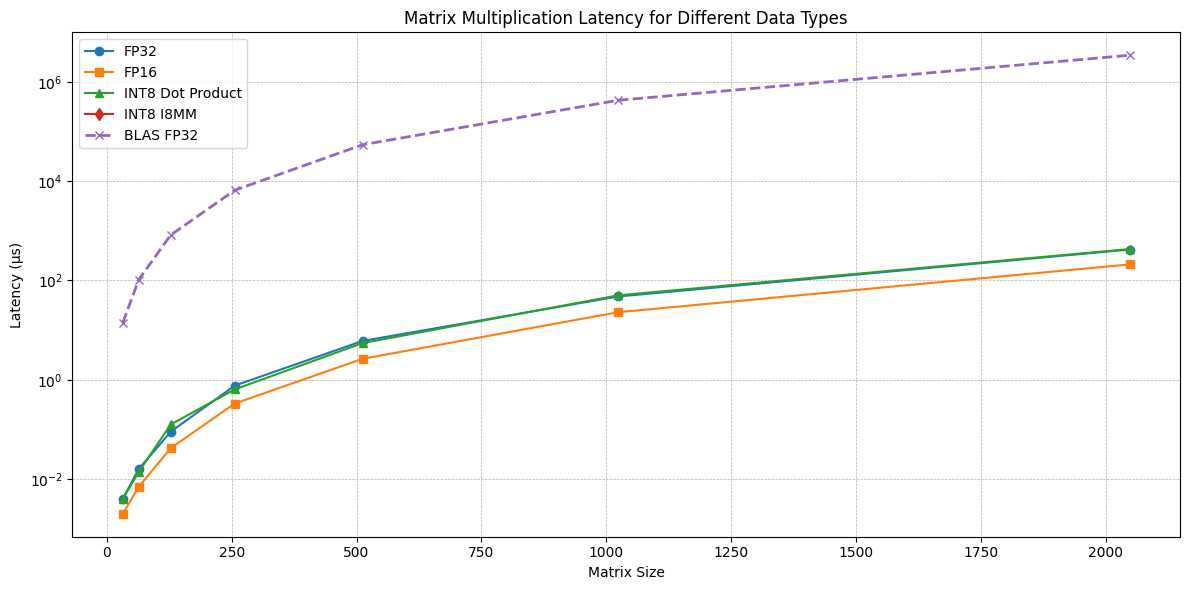

In [19]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 

# Load datasets
f32_data = pd.read_csv("src/cpp/results/f32_scaling_results.csv")
f16_data = pd.read_csv("src/cpp/results/f16_scaling_results.csv")
int8_dotprod_data = pd.read_csv("src/cpp/results/i8_dotprod_scaling_results.csv")
int8_i8mm_data = pd.read_csv("src/cpp/results/i8_i8mm_scaling_results.csv")
blas_data = pd.read_csv("src/cpp/results/blas_f32_scaling_results.csv")

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot each dataset
plt.plot(f32_data['Size'], f32_data['Latency(us)'], label="FP32", marker='o')
plt.plot(f16_data['Size'], f16_data['Latency(us)'], label="FP16", marker='s')
plt.plot(int8_dotprod_data['Size'], int8_dotprod_data['Latency(us)'], label="INT8 Dot Product", marker='^')
plt.plot(int8_i8mm_data['Size'], int8_i8mm_data['Latency(us)'], label="INT8 I8MM", marker='d')
plt.plot(blas_data['Size'], blas_data['Latency(us)'], label="BLAS FP32", marker='x', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel("Matrix Size")
plt.ylabel("Latency (µs)")
plt.title("Matrix Multiplication Latency for Different Data Types")
plt.yscale('log')  # Use log scale for latency if the values span multiple orders of magnitude
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()



# watch the blas fp32 process

In [20]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/blas/build/blas_f32_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 40949


In [21]:
!sudo ./processwatch/processwatch -p 40949-f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              0.00     0.00     0.00     0.00     100.00   25279   
40949    blas_f32_inf     0.00     0.00     0.00     0.00     100.00   25279   

PID      NAME             SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              0.00     0.00     0.00     0.00     100.00   26596   
40949    blas_f32_inf     0.00     0.00     0.00     0.00     100.00   26596   
^C


In [22]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# watch the kleidiai FP32 process 

In [23]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_f32_f32p/build/kai_f32_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 40979


In [24]:
!sudo ./processwatch/processwatch -p 40979 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              70.70    0.00     0.00     0.00     0.00     100.00   25241   
40979    kai_f32_inf      70.70    0.00     0.00     0.00     0.00     100.00   25241   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              70.75    0.00     0.00     0.00     0.00     100.00   26571   
40979    kai_f32_inf      70.75    0.00     0.00     0.00     0.00     100.00   26571   
^C


In [25]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# watch the kleidiai FP16 process 

In [26]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f16_f16_f16p/build/kai_f16_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 41009


In [27]:
!sudo ./processwatch/processwatch -p 41009 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              83.85    0.00     0.00     0.00     0.00     100.00   25200   
41009    kai_f16_inf      83.85    0.00     0.00     0.00     0.00     100.00   25200   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              83.90    0.00     0.00     0.00     0.00     100.00   26517   
41009    kai_f16_inf      83.90    0.00     0.00     0.00     0.00     100.00   26517   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              83.93    0.00     0.00     0.00     0.00     100.00   25219   
41009    kai_f16_inf      83.93    0.00     0.00     0.00     0.00     100.00   25219   
^C


In [29]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# watch the kleidiai INT8/4 DotProd process 

In [30]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_i8_i4_dotprod/build/kai_i8_dotprod_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 41077


In [31]:
!sudo ./processwatch/processwatch -p 41077 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              57.83    0.00     0.00     0.00     5.37     100.00   25290   
41077    kai_i8_dotprod_  57.83    0.00     0.00     0.00     5.37     100.00   25290   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              57.65    0.00     0.00     0.00     5.49     100.00   26615   
41077    kai_i8_dotprod_  57.65    0.00     0.00     0.00     5.49     100.00   26615   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              58.20    0.00     0.00     0.00     5.44     100.00   25301   
41077    kai_i8_dotprod_  58.20    0.00     0.00     0.00     5.44     100.00   25301   
^C


In [32]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# watch the kleidiai int8/4 i8mm process

In [33]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_i8_i4_i8mm/build/kai_i8_i8mm_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 41106


In [34]:
!sudo ./processwatch/processwatch -p 41106 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              42.02    0.00     0.00     6.16     0.00     100.00   25293   
41106    kai_i8_i8mm_inf  42.02    0.00     0.00     6.16     0.00     100.00   25293   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              41.26    0.00     0.00     6.55     0.00     100.00   26598   
41106    kai_i8_i8mm_inf  41.26    0.00     0.00     6.55     0.00     100.00   26598   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              41.44    0.00     0.00     6.57     0.00     100.00   25285   
41106    kai_i8_i8mm_inf  41.44    0.00     0.00     6.57     0.00     100.00   25285   
^C


In [35]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# Onto KLEIDIAI Integrations with torch. Lets start by using the 4bit weight only kernel

In [36]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torchao.quantization.utils import prepare_int4_weight_and_scales_and_zeros
from torchao.utils import find_multiple

### Set some matmul hyperparameters 

In [37]:
out_features = 256 
in_features = 128
groupsize = 32 
inner_k_tiles = 8

### Create the floating point matrices 

In [38]:
weight = torch.randn(out_features, in_features, dtype=torch.float32)
x = torch.randn(1, in_features, dtype=torch.float32)

## use torchao to perform the group quantization 

In [39]:
w_int4x8, scales_and_zeros = prepare_int4_weight_and_scales_and_zeros(
    weight, 
    groupsize, 
    inner_k_tiles, 
    "symmetric_groupwise", 
    precision=torch.float32,
)

### Look at the shapes to see what has been done 

In [40]:
print(f"Full Precision weights: shape {weight.shape} dtype {weight.dtype}")
print(f"Prepared weights: shape {w_int4x8.shape} dtype {w_int4x8.dtype}")
print(" ")
print("weight number equality: ", w_int4x8.numel(), "==", weight.numel()//2 + (weight.numel()//groupsize * 2))

Full Precision weights: shape torch.Size([256, 128]) dtype torch.float32
Prepared weights: shape torch.Size([1024, 18]) dtype torch.uint8
 
weight number equality:  18432 == 18432


**Explanation of the Prepared Weights Size**

We can see above that the following equality between the number of weights in the prepared quantized weights (w-int4x8) and the original weights (weight) is true. 

```python
w_int4x8.numel() == (weight.numel() // 2) + (weight.numel() // groupsize * 2) 
```

***NOTE: weight.numel() gives the number of elements inside a pytorch tensor***

This can be explained by our use of 4-bit quantization in which we need to pack the quantized weights in addition to it's scale parameters into the w_int4x8 tensor. To do so, this can be interpreted in two parts:

1. **Half the number of weights**:  
   - Because each original weight is mapped to a 4-bit number, and two 4-bit values fit in a single byte, we only need half as many bytes as the total number of full-precision weights.  
   - This is expressed by `(weight.numel() // 2)` in the weight number equality.

2. **Storage for scale parameters**:  
   - Each group of weights has a corresponding scale factor, and the number of groups is `(weight.numel() // groupsize)`.  
   - These scale factors are stored in `float16` format, which requires 2 bytes for each scale, leading to `* 2`.  
   - Hence, the term `(weight.numel() // groupsize * 2)` accounts for the total bytes needed for all scale factors.

Therefore, when you add these two parts:

```python
(weight.numel() // 2) + (weight.numel() // groupsize * 2) 
```

you get the total storage (in bytes) for the quantized weights plus the scale parameters. This total matches the number of elements in `w_int4x8`, ensuring the shape `torch.Size([1024, 18])` correctly reflects both packed 4-bit weights and their scale factors.


**Explanation of the Prepared Weights shape**

In [41]:
w_int4x8.shape

torch.Size([1024, 18])

The weight preparation function has performed group quantization, quantizing each group to a single row in the matrix. This gives `weight.numel()s//group_size` rows. We can check that it is true using the below line 

In [42]:
weight.numel() // groupsize

1024

ok so that means that there is one group per row, each one with their own scale parameter. Given that the groupsize we have used is 32, and when using 4-bit quantization we can pack 2 elemtns into a single byte, that gives a row size of 16 bytes. This leaves a discrepancy of 2 bytes. This 2 byte difference is used to hold the symmetric scale parameter in float16 format. Therefore the row size of w_int4x8 is: 

In [43]:
groupsize // 2 + 2

18

# Lets now use the kleidiai kernel that has been integrated into torch 
after performing the quantization, we must pack the weight into a shape required by the kleidiai kernels. This, is a memory optimization step. 

In [44]:
weight_int4pack = torch.ops.aten._kai_weight_pack_int4(w_int4x8, scales_and_zeros.float(), out_features, in_features, groupsize)

# define a forward function to use the kleidi kernel 

In [45]:
def linear_forward_int4_symmetric_groupwise(x, weight_int4pack, out_features, in_features):
    origin_x_size = x.size()
    c = torch.ops.aten._kai_input_quant_mm_int4(x, weight_int4pack, x.shape[-2],out_features, in_features, 32)
    new_shape = origin_x_size[:-1] + (out_features,)
    c = c.reshape(new_shape)
    return c


In [46]:
out_kai = linear_forward_int4_symmetric_groupwise(x, weight_int4pack, out_features, in_features)

# lets check the quantization error compared to the fp32 multiplication 

In [47]:
out_baseline = torch.matmul(x, weight.T) # compute the baseline operation
print(out_kai.flatten()[:5])
print(out_baseline.flatten()[:5])
error = (out_baseline - out_kai).abs() / out_baseline.abs()

tensor([10.7431, -0.0724, -6.2523,  3.7692, -3.8037])
tensor([10.5821, -0.0892, -7.1642,  3.7358, -4.9737])


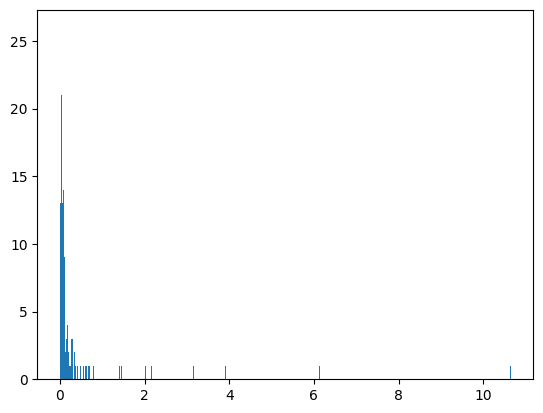

In [48]:
import matplotlib.pyplot as plt 
plt.hist(error.flatten().numpy(), bins=1000)
plt.show()

## Quantizing A model with KleidiAI
define a 4-bit weight only linear using kleidiai kernel

In [60]:
class Int4WeightOnlyKAILinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True): 
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.register_buffer(
            "weight",
            torch.zeros((torch.ops.aten.get_kai_weight_pack_int4_size(out_features,in_features,groupsize)), dtype=torch.uint8)
        )

        self.register_buffer(
            "scales_and_zeros",
            torch.zeros((0), dtype=torch.float32)
        )

        if bias is not False: 
            self.register_buffer(
                "bias",
                torch.zeros((self.out_features), dtype=torch.float32)
            )
        else: 
            self.register_buffer("bias", None)

    def forward(self, x):
        print("4bitint")
        out = linear_forward_int4_symmetric_groupwise(x, self.weight, self.out_features, self.in_features)
        if self.bias is not None:
            out += self.bias 
        return out

define function to return quantized version of layer

In [61]:
def quantize_linear_layer(layer):
    fp_weight = layer.weight.data.detach()
    out_features = layer.out_features
    in_features = layer.in_features

    w_int4x8, scales_and_zeros = prepare_int4_weight_and_scales_and_zeros(
        fp_weight, 
        groupsize=32, # groupsize
        inner_k_tiles=8, # inner_k_tiles 
        scheme="symmetric_groupwise", 
        precision=torch.float32
    )

    weight_int4pack = torch.ops.aten._kai_weight_pack_int4(
        w_int4x8, 
        scales_and_zeros.float(), 
        out_features, 
        in_features, 
        groupsize
    )

    use_bias = layer.bias is not None
    layer4bit = Int4WeightOnlyKAILinear(in_features, out_features, use_bias)

    layer4bit.weight = weight_int4pack
    layer4bit.scales_and_zeros = scales_and_zeros
    if use_bias:
        layer4bit.bias.data.copy_(layer.bias.data)

    return layer4bit


define function to quantize an entire nn.Module inplace

In [62]:
def quantize_model(model):
    for name, child in model.named_children():
        if isinstance(child, nn.Linear):
            # Quantize the linear layer
            quantized_layer = quantize_linear_layer(child)
            setattr(model, name, quantized_layer)
        else:
            # Recursively apply to child modules
            quantize_model(child)
    return model


create the model

In [63]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer


model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)

prompt = "Arm is a company that" 
inputs = tokenizer(prompt, return_tensors="pt")

Lets sample a generation from the model

In [64]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

generated_ids = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
generated_text_fp = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
generated_text_fp

'Arm is a company that has been in the business of manufacturing and supplying various types of'

before quantizing get full precision memory consumption

In [65]:
import torch

baseline_memory_consumption = 0  # Memory in bytes
for name, param in model.named_parameters():  # Use model.named_parameters() to iterate over model parameters
    baseline_memory_consumption += param.numel() * param.element_size()

# Convert to megabytes (MB)
baseline_memory_consumption_mb = baseline_memory_consumption / (1024 ** 2)

print(f"Baseline memory consumption: {baseline_memory_consumption_mb:.2f} MB")

Baseline memory consumption: 1035.79 MB


before quantizing get the full precision generation latency 

In [66]:
import time
    
baseline_latency = 0
for _ in range(10):
    st = time.time()
    model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
    et = time.time()
    baseline_latency += (et - st) * 1000
baseline_latency /= 10

print(f"Time taken: {baseline_latency:.2f} ms")

Time taken: 435.45 ms


qauntize the model 

In [56]:
quantize_model(model.transformer)

OpenELMModel(
  (token_embeddings): Embedding(32000, 1280)
  (layers): ModuleList(
    (0-4): 5 x OpenELMDecoderLayer(
      (attn): OpenELMMultiHeadCausalAttention(
        query_heads=12, key_heads=3, value_heads=3
        (qkv_proj): Int4WeightOnlyKAILinear()
        (pos_embedding): OpenELMRotaryEmbedding(	model_dim=64, max_seq_length=4096, freq_constant=10000)
        (q_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
        (k_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
        (out_proj): Int4WeightOnlyKAILinear()
      )
      (ffn): OpenELMFeedForwardNetwork(
        (ffn_with_glu) : True
        (proj_1): Int4WeightOnlyKAILinear()
        (proj_2): Int4WeightOnlyKAILinear()
        (act): SiLU()
      )
      (ffn_norm): OpenELMRMSNorm(num_features=1280, eps=1e-06)
      (attn_norm): OpenELMRMSNorm(num_features=1280, eps=1e-06)
    )
    (5-11): 7 x OpenELMDecoderLayer(
      (attn): OpenELMMultiHeadCausalAttention(
        query_heads=16, key_heads=4, value_heads=4


Get the quantized memory consumption

In [57]:
import torch

quantized_memory_consumption = 0  # Memory in bytes
for name, param in model.named_parameters():  # Use model.named_parameters() to iterate over model parameters
    quantized_memory_consumption += param.numel() * param.element_size()

# Convert to megabytes (MB)
quantized_memory_consumption_mb = quantized_memory_consumption / (1024 ** 2)

print(f"Baseline memory consumption: {quantized_memory_consumption_mb:.2f} MB")

Baseline memory consumption: 156.42 MB


Get the quantized latency

In [59]:
import time

quantized_latency = 0
for _ in range(10):
    st = time.time()
    model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
    et = time.time()
    quantized_latency += (et - st) * 1000
quantized_latency /= 10

print(f"Time taken: {quantized_latency:.2f} ms")

Time taken: 436.31 ms


generate from the quantized model 

In [62]:
generated_ids = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
generated_text_4bit = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
generated_text_4bit

'Arm is a company that specializes in the design, manufacture, and installation of custom-'